In [1]:
print("Prior to running this code, run ProcessCalciumMEALowpass.py")

Prior to running this code, run ProcessCalciumMEALowpass.py


In [2]:
import pandas as pd
import os
from pathlib import Path

def process_lat_data(base_dir, condition, output_filename):
    # Create paths
    lat_dir = base_dir  # No need for LAT_data subdirectory
    output_path = os.path.join(base_dir, output_filename)
    
    # Collect all channel data
    all_data = {}
    max_spikes = 0
    
    # Find all channel files directly
    pattern = f"{condition}_channel_*_lat_results.csv"
    for csv_file in Path(lat_dir).glob(pattern):
        # Extract channel number from filename
        channel_str = csv_file.stem.split('_channel_')[1].split('_')[0]
        channel = int(channel_str)
        
        df = pd.read_csv(csv_file)
        if not df.empty:
            lat_times = df['lat_time'].tolist()
            all_data[channel] = lat_times
            max_spikes = max(max_spikes, len(lat_times))
    
    # Create DataFrame
    columns = [f"Spike_{i+1}" for i in range(max_spikes)]
    result_df = pd.DataFrame(index=sorted(all_data.keys()), columns=columns)
    
    # Fill DataFrame
    for channel, lat_times in all_data.items():
        for i, time in enumerate(lat_times):
            result_df.at[channel, f"Spike_{i+1}"] = time
    
    # Normalize columns
    normalized_df = result_df.apply(lambda col: col - col.min())
    
    # Add empty first row
    empty_df = pd.DataFrame(columns=normalized_df.columns)
    # Ensure empty first row is added correctly
    empty_row = pd.Series([None] * len(normalized_df.columns), index=normalized_df.columns)
    final_df = pd.concat([pd.DataFrame([empty_row]), normalized_df], ignore_index=True)

    
    # Save to Excel
    final_df.to_excel(output_path, index=False, header=False)
    
    print(f"Saved normalized LAT data to {output_path}")
    return final_df

# Usage
base_directory = "results/"

condition_name = "JKCO6IsoCalcium"
output_file = "latency.xlsx"

final_data = process_lat_data(base_directory, condition_name, output_file)

Saved normalized LAT data to results/latency.xlsx


In [3]:
print("This code calculate 3D velocities. Remeber to add empty row in xlsx")
import pandas as pd

# Load the Excel file
df = pd.read_excel('results/latency.xlsx')

# Convert the DataFrame to a 2D array
latencies = df.values*10
print(latencies)
print(latencies.shape)

This code calculate 3D velocities. Remeber to add empty row in xlsx
[[0.299 0.247 0.273 0.332 0.304 0.278 0.236 0.238 0.254 0.244 0.23  0.298
  0.288 0.262 0.266 0.218 0.327 0.284 0.302 0.278]
 [0.298 0.245 0.268 0.331 0.304 0.278 0.231 0.237 0.253 0.24  0.227 0.293
  0.282 0.261 0.265 0.223 0.325 0.282 0.299 0.278]
 [0.407 0.349 0.38  0.441 0.4   0.384 0.339 0.344 0.361 0.356 0.337 0.402
  0.392 0.37  0.371 0.331 0.428 0.391 0.405 0.385]
 [0.413 0.358 0.385 0.445 0.409 0.397 0.347 0.351 0.366 0.36  0.343 0.406
  0.399 0.374 0.379 0.338 0.436 0.395 0.411 0.392]
 [0.403 0.347 0.376 0.436 0.4   0.386 0.338 0.338 0.359 0.355 0.337 0.399
  0.392 0.365 0.372 0.33  0.428 0.389 0.408 0.384]
 [0.409 0.351 0.381 0.44  0.405 0.386 0.339 0.345 0.363 0.357 0.338 0.402
  0.395 0.372 0.374 0.331 0.432 0.391 0.405 0.387]
 [0.437 0.362 0.391 0.456 0.429 0.413 0.354 0.362 0.378 0.365 0.359 0.415
  0.412 0.383 0.388 0.352 0.445 0.406 0.427 0.4  ]
 [0.421 0.364 0.393 0.451 0.418 0.398 0.353 0.358 0.375 0

In [4]:
import numpy as np
latency = np.mean(latencies, axis=1)*1000 #it should be in the unit of 0.1 ms so the result is in cm/s
print(latency.shape)

(14,)


In [5]:


latitudes = np.array([ 0,   60, 60,   0,     0, -60, 60,     0, 0     ,-60  , 60, 0   ,     0,  -60,  -60,      0])
#correcting latitude

latitudes = np.array([ 0,   -60, 60,   0,     0, -60, 60,     0, 0     ,-60  , 60, 0   ,     0,  -60,  60,      0])
longitudes = np.array([22.5, 0, 90,67.5, 112.5, 90, 180, 157.5, -157.5, 180 ,-90,-112.5, -67.5,  -90,  0, -22.5])

target_indices = [0,1,2,3,4,5,8,9,10,11,12,13,14,15]
print(len(target_indices))
latitudes = latitudes[target_indices]
longitudes = longitudes[target_indices]


14


In [6]:
latency.max() - latency.min()

396.6999999999944

In [7]:
print("Define Fitting Functions")
import sys
import os
sys.path.append(os.path.abspath("../"))

import matplotlib.pyplot as plt

from electrophysiology_mapping.spike import *
from electrophysiology_mapping.triangular import *
from electrophysiology_mapping.map import *
import numpy as np
import matplotlib.pyplot as plt


def Frbf(d, epsilon, method='inverse_multiquadric'):
    if method == 'inverse_quadratic':
        return 1 / (1 + (d/epsilon)**2)
    else:
        raise ValueError("Unsupported method. Supported method: inverse_quadratic")

def calculate_distance_vector(longitudes, latitudes, target_lon, target_lat):
    """
    Calculate the distance matrix for arrays of longitudes and latitudes.
    """
    n = len(longitudes)
    vector = np.zeros((n))
    for i in range(n):
        vector[i] = haversine(longitudes[i], latitudes[i], target_lon, target_lat)
    return vector

def interpolate(new_distances, lambda_, epsilon, method='gaussian'):
    return np.dot(Frbf(new_distances, epsilon=epsilon, method=method), lambda_)

def grid_fitting_rbf_sphere(latency, longitudes, latitudes, distance_matrix,
        size_x=605, size_y=300, save=0, file_address='contour_sphere.png', electrodes=1, plot=1,
        colorbar=0, target_long=None, target_lat=None, divide_time_by=1,
        dense=1, color='black', epsilon=300.0, method='gaussian',levels=np.linspace(0, 50, 100)):

    latency = latency/divide_time_by
    A = Frbf(distance_matrix, epsilon=epsilon, method=method)
    lambda_ = np.linalg.solve(A, latency)

    if target_long is None:
        longitudes_grid = np.linspace(-180, 180, size_x)
        latitudes_grid = np.linspace(-90, 90, size_y)
        grid_x, grid_y = np.meshgrid(longitudes_grid, latitudes_grid)
        grid_x = grid_x.T
        grid_y = grid_y.T
        grid_z = np.zeros_like(grid_x)

        for i in range(grid_z.shape[0]):
            for j in range(grid_z.shape[1]):
                new_point_distances = calculate_distance_vector(
                    longitudes, latitudes, grid_x[i,j], grid_y[i,j])
                grid_z[i,j] = interpolate(new_point_distances, lambda_, epsilon=epsilon, method=method)/10
        
        fig, ax = plt.subplots(figsize=(8, 4))
        
        contour = ax.contourf(grid_x, grid_y, grid_z, levels=levels, cmap='jet')
        if electrodes:
            plt.scatter(longitudes, latitudes, c=color, edgecolor='k') 

        if save:
            ax.axis('off')
            plt.tight_layout(pad=0)
            fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
            fig.savefig(file_address, bbox_inches='tight', pad_inches=0, dpi=600)
            plt.close(fig)
        elif plot:
            plt.axis('equal')
            plt.xlim([-180,180])
            plt.ylim([-90,90])
            if colorbar:
                colorbar = plt.colorbar(contour)
                colorbar.set_label('Latency (ms)')
            plt.show()
        if not plot:
            plt.close()

    else:
        grid_z = []
        for longitude, latitude in zip(target_long, target_lat):
            new_point_distances = calculate_distance_vector(
                    longitudes, latitudes, longitude, latitude)
            grid_z.append(interpolate(new_point_distances, lambda_, epsilon=epsilon, method=method))
        grid_z_array = np.array(grid_z)

        return grid_z_array

    interpolated_at_original = np.dot(A, lambda_)
    difference = np.abs(interpolated_at_original - latency)
 
    
    grid_variables = {
        "grid_x_full": grid_x,
        "grid_y_full": grid_y,
        "grid_z_full": grid_z,
        "grid_x_target": grid_x,
        "grid_y_target": grid_y,
        "grid_z_target": grid_z
    }
        
    return grid_variables



def grid_fitting_rbf_sphere(latency, longitudes, latitudes, distance_matrix,
        size_x=605, size_y=300, save=0, file_address='contour_sphere_electrodeNumber.png', electrodes=1, plot=1,
        colorbar=0, target_long=None, target_lat=None, divide_time_by=1,
        dense=1, color='black', epsilon=300.0, method='gaussian', levels=np.linspace(0, 50, 100),
        electrode_index=None):

    latency = latency / divide_time_by
    A = Frbf(distance_matrix, epsilon=epsilon, method=method)
    lambda_ = np.linalg.solve(A, latency)

    if target_long is None:
        longitudes_grid = np.linspace(-180, 180, size_x)
        latitudes_grid = np.linspace(-90, 90, size_y)
        grid_x, grid_y = np.meshgrid(longitudes_grid, latitudes_grid)
        grid_x = grid_x.T
        grid_y = grid_y.T
        grid_z = np.zeros_like(grid_x)

        for i in range(grid_z.shape[0]):
            for j in range(grid_z.shape[1]):
                new_point_distances = calculate_distance_vector(
                    longitudes, latitudes, grid_x[i, j], grid_y[i, j])
                grid_z[i, j] = interpolate(new_point_distances, lambda_, epsilon=epsilon, method=method) / 10
        
        fig, ax = plt.subplots(figsize=(8, 4))
        contour = ax.contourf(grid_x, grid_y, grid_z, levels=levels, cmap='jet')
        #contour_lines = ax.contour(grid_x, grid_y, grid_z, levels=levels, colors='black', linewidths=0.5)

        if electrodes:
            plt.scatter(longitudes, latitudes, c=color, edgecolor='k') 
            if electrode_index is not None:
                for idx, (lon, lat) in enumerate(zip(longitudes, latitudes)):
                    plt.text(lon, lat, str(electrode_index[idx]), color='black', fontsize=8, ha='right')

        if save:
            ax.axis('off')
            plt.tight_layout(pad=0)
            fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
            fig.savefig(file_address, bbox_inches='tight', pad_inches=0, dpi=600)
            plt.close(fig)
        elif plot:
            plt.axis('equal')
            plt.xlim([-180, 180])
            plt.ylim([-90, 90])
            if colorbar:
                colorbar = plt.colorbar(contour)
                colorbar.set_label('Latency (ms)')
            plt.show()
        if not plot:
            plt.close()
    else:
        grid_z = []
        for longitude, latitude in zip(target_long, target_lat):
            new_point_distances = calculate_distance_vector(
                longitudes, latitudes, longitude, latitude)
            grid_z.append(interpolate(new_point_distances, lambda_, epsilon=epsilon, method=method))
        grid_z_array = np.array(grid_z)

        return grid_z_array

    interpolated_at_original = np.dot(A, lambda_)
    difference = np.abs(interpolated_at_original - latency)
 

    grid_variables = {
        "grid_x_full": grid_x,
        "grid_y_full": grid_y,
        "grid_z_full": grid_z,
        "grid_x_target": grid_x,
        "grid_y_target": grid_y,
        "grid_z_target": grid_z
    }

    return grid_variables



Define Fitting Functions


plotting 200 epsilon


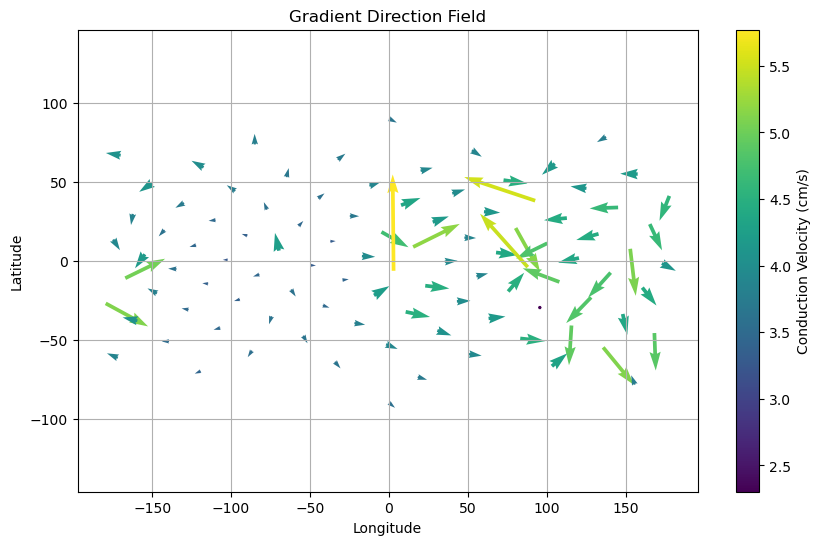

e:\Desktop\omipolar\DataPlotting\organoid_map3d\electrophysiology_mapping\map.py:1525: RuntimeWarning: invalid value encountered in divide
  direction = direction / np.linalg.norm(direction)
e:\Desktop\omipolar\DataPlotting\organoid_map3d\electrophysiology_mapping\map.py:1526: RuntimeWarning: divide by zero encountered in log
  add_arrow(renderer, position, direction, scale * np.log(np.log(amplitude) + 5), color)
e:\Desktop\omipolar\DataPlotting\organoid_map3d\electrophysiology_mapping\map.py:1526: RuntimeWarning: invalid value encountered in log
  add_arrow(renderer, position, direction, scale * np.log(np.log(amplitude) + 5), color)


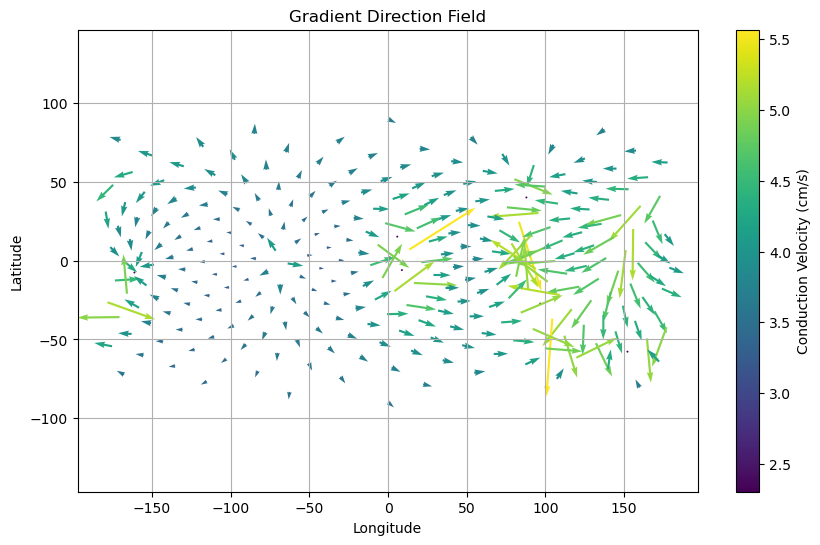

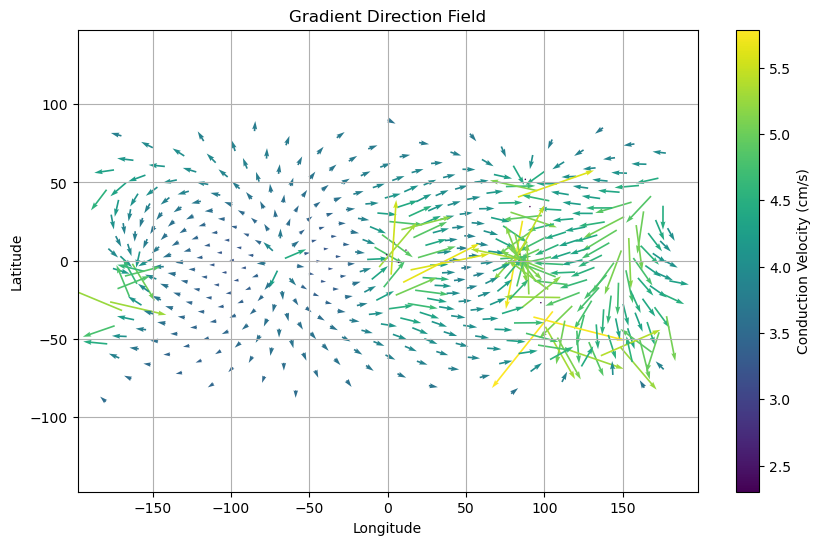

In [8]:
print("plotting 200 epsilon")
import numpy as np
import os

# Define the subfolder name
subfolder = "SmootherMap"
all_index = np.array([8 ,9 ,10,11,12,13,14,15,
             24,25,26,27,28,29,30,31])
# Create the subfolder if it doesn't exist
os.makedirs(subfolder, exist_ok=True)
data = {}
file_addresses = []
distance_matrix = calculate_distance_matrix(longitudes, latitudes) #radius = 250 by default

for epsilon in[200]:  # Loop from 200 to 700 with step of 50
    file_name = f'contour_arhythmia_epsilon_{epsilon}_0_50_test.png'
    file_path = os.path.join(subfolder, file_name)  # Save in the subfolder
    file_addresses.append(file_path)

    grid_sphere = grid_fitting_rbf_sphere(
        latency, longitudes, latitudes, distance_matrix,
        plot=0, save=1, colorbar=1, electrodes=0,
        epsilon=epsilon, file_address=file_path,
        method='inverse_quadratic', 
        electrode_index=all_index[target_indices],
        levels=np.linspace(-0.3, 49.7, 500)
    )


    for sample, scale, directory in zip([100, 300, 500], [0.08,0.08,0.08], ["100_Vectors","300_Vectors","500_Vectors"]):
        vectors_sphere = create_vector_field_spherical_coords_grids(grid_sphere['grid_x_target'],
                            grid_sphere['grid_y_target'],
                            grid_sphere['grid_z_target'],
                            samples=sample, r = 610, deltaD = None)
        amp_sph = np.sqrt(np.array(vectors_sphere['us'])**2+np.array(vectors_sphere['vs'])**2)/10
        setup_scene_and_capture(vectors_sphere['points'],vectors_sphere['us'],vectors_sphere['vs'],CV_threshold= 100, projection = False,
                            texture_file='blank_contour.png', rotate_z=180, scale= scale, directory= ".\\200CVMapping\\3D\\"+directory)
        # Create heading with mean, median, and std
        setup_scene_and_capture(vectors_sphere['points'],vectors_sphere['us'],vectors_sphere['vs'],CV_threshold= 100, projection = True,
                            texture_file='blank_contour.png', rotate_z=180, scale= scale, directory= ".\\200CVMapping\\2D\\"+directory)
        # Create heading with mean, median, and std
        amp_sph = np.sqrt(np.array(vectors_sphere['us'])**2+np.array(vectors_sphere['vs'])**2)/10
        directory=directory+"withBg"
        setup_scene_and_capture(vectors_sphere['points'],vectors_sphere['us'],vectors_sphere['vs'],CV_threshold= 100, projection = False,
                            texture_file=file_path, rotate_z=180, scale= scale, directory= ".\\200CVMapping\\3D\\"+directory)
        # Create heading with mean, median, and std
        setup_scene_and_capture(vectors_sphere['points'],vectors_sphere['us'],vectors_sphere['vs'],CV_threshold= 100, projection = True,
                            texture_file=file_path, rotate_z=180, scale= scale, directory= ".\\200CVMapping\\2D\\"+directory)
        # Create heading with mean, median, and std

        directory=directory+"OnlyBG"
        setup_scene_and_capture([],[],[],CV_threshold= 100, projection = False,
                            texture_file=file_path, rotate_z=180, scale= scale, directory= ".\\200CVMapping\\3D\\"+directory)
        # Create heading with mean, median, and std
        setup_scene_and_capture([],[],[],CV_threshold= 100, projection = True,
                            texture_file=file_path, rotate_z=180, scale= scale, directory= ".\\200CVMapping\\2D\\"+directory)
        # Create heading with mean, median, and std
        heading = f'CV amplitude (cm/s) with {sample} samples (Mean: {np.mean(amp_sph):.2f}, Median: {np.median(amp_sph):.2f}, Std: {np.std(amp_sph):.2f})'
        
        # Create heading with mean, median, and std
    
        data[heading] = amp_sph

# Convert to DataFrame and save to Excel
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data.items()]))
df.to_excel('CV_results.xlsx', index=False)


